In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import allensdk
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
from PIL import Image
from sklearn.model_selection import train_test_split
import cvxpy

# Data Access & Preprocessing

### Load Cache To Access & Manage Data

In [2]:
def load_cache():
    '''
    Load the cache containing allensdk dataset 
    '''
    # this path determines where downloaded data will be stored
    manifest_path = os.path.join('/local1/ecephys_cache_dir/', "manifest.json")
    return EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
cache = load_cache()

### Load Session Data

In [4]:
def get_session_ids(cache, stimulus_type='functional_connectivity'):
    '''
    Get a list of session id's in the dataset with [stimulus_type] stimulus shown
    '''
    sessions = cache.get_session_table()
    return sessions[sessions["session_type"] == stimulus_type].index.values

def load_session_by_id(cache, session_id):
    '''
    Get the session data for the given session id from the given data cache
    '''
    
    print('Loading session {0} ...'.format(session_id), end='')

    sess = cache.get_session_data(session_id)
    
    print('done')
    return sess
 
def load_session_by_idx(cache, idx):
    ''' 
    Given an index between [0, ..., num_sessions], get a session corresponding to index
    return the session data and the session id
    '''
    
    session_id = get_session_ids(cache)[idx]
    return load_session_by_id(cache, session_id), session_id


In [5]:
session, session_id = load_session_by_idx(cache, -2)

Loading session 840012044 ...done


### Extract Stimulus Presentation Data

In [6]:
def get_neurons_by_region(session, region):
    '''
    Return a list of neuron (unit) id's according to their anatomical region e.g. "VISp" for primary visual cortex
    '''
    return session.units.loc[session.units.ecephys_structure_acronym==region].index.values
    
def get_stim_experiment_data(session, stim_name='natural_movie_one_more_repeats', region = 'VISp'):
    '''
    Return a pd dataframe of stimulus presentation information (e.g. frame,  time, etc.) for the stimulus [stimulus_name]
    if presented in the session
    '''
    print('Loading experiment stimulus data...', end='')

    stim_table = session.stimulus_presentations
    stim_table = stim_table.loc[stim_table.stimulus_name==stim_name,  :]
    
    #stim_table.start_time = np.unwrap(stim_table.start_time)
    t_start = stim_table.start_time.values[0]
    t_end = stim_table.start_time.values[-1]
    
    print('done')
    
    return {
        'stim_table' : stim_table,
        't_start' : t_start,
        't_end' : t_end,
        'units' : session.units.index.values, #get_neurons_by_region(session, region),
        'refresh_rate' : np.diff(stim_table.start_time.values)[0]
    }

def get_presentation_times(stim_data):
    '''
     Return the times at which each image is presented as an ndarray. 
    '''
    t_start = stim_data['stim_table'].start_time.values[0]
    t_end = stim_data['stim_table'].start_time.values[-1]
  
    ts = stim_data['stim_table'].start_time.values
    ts = ts[ts < t_end]
    ts = ts[ts > t_start]
    
    return ts
    
def get_stimulus_frames(cache, stim_name='natural_movie_one_more_repeats', desired_size=None):
    '''
    Return the frames (pixel data) of the stimulus given by [stim_name]. The 
    resulting numpy array has shape (num_frames, num_pixels_x, num_pixels_y). If desired size is specified,
    resulting frames are resized/resampled. 
    '''
    if stim_name == 'natural_movie_one_more_repeats':
        frames = cache.get_natural_movie_template(1)
    else:
        assert(False), "Bad Stim Name"
        
    if desired_size:
        resized_frames = np.zeros((frames.shape[0], desired_size[1], desired_size[0]), dtype=np.int16)
        for i in range(frames.shape[0]):
            img = Image.fromarray(frames[i,:,:])
            resized_image = img.resize(size = desired_size)            
            resized_frames[i,:,:] = np.asarray(resized_image, dtype = np.int16) - 128
            resized_frames[i,:,:] -= np.mean(resized_frames[i,:,:]).astype(np.int16)
        
        return resized_frames
    else:
        return None
    
def get_presentation_frame_numbers(stim_data):
    '''
    Return which frames were presented at each time step. Provides indexes to access output 
    from get_stimulus_frames. Each frame number is between [0, num_frames].
    '''
    return stim_data['stim_table'].frame.values.astype(np.int)

In [7]:
stim_data =  get_stim_experiment_data(session)
h_res = 128
v_res = 64
movie = get_stimulus_frames(cache, desired_size = (h_res, v_res))
frames = get_presentation_frame_numbers(stim_data)
num_neurons = len(stim_data['units'])

Loading experiment stimulus data...done


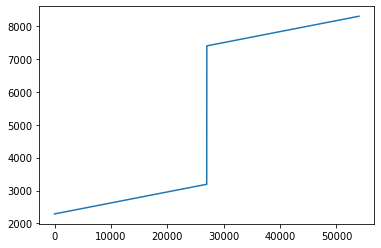

In [143]:

plt.plot(ts)



### Load and Bin Spike Data

In [164]:
def get_spike_data(session, stim_data):
    '''
    Given a session, return the spike times for units (probes) lying between t_start and t_end
    as a dictionary with keys [unit_number] and values [list(spike times for unit_number)]. 
    '''
    
    def remove_invalid_spike_times(session, spike_times):
        '''
        Remove spikes that occur between any invalid spike times

        Arguments:
            - session : a Ecephys Session Object
            - spike_times : a (num_timesteps, 1) numpy array of spike times over a given time interval
        '''

        clean_spike_times = spike_times.copy()
        assert(np.all(clean_spike_times == spike_times))

        invalid_table = session.invalid_times 
        num_invalid_intervals = len(invalid_table.index)

        invalid_starts = invalid_table.start_time.values
        invalid_stops = invalid_table.stop_time.values
        assert(len(invalid_starts) == len(invalid_stops))

        num_removed_spikes = 0
        for j in range(num_invalid_intervals):
            start = invalid_starts[j]
            stop = invalid_stops[j]
            invalid_spikes_mask = (clean_spike_times >= start) & (clean_spike_times < stop) 
            clean_spike_times = clean_spike_times[ ~invalid_spikes_mask]
            num_removed_spikes += np.sum(invalid_spikes_mask)
            assert(len(spike_times) - len(clean_spike_times) == num_removed_spikes)

        return clean_spike_times

    print('Extracting spike data ...', end='')
    spike_times = {}
    units = stim_data['units']
    t_start = stim_data['t_start']
    t_end = stim_data['t_end']
    
    
    
    for unit in units:
        this_unit_spikes = session.spike_times[unit].copy()
        this_unit_spikes = this_unit_spikes[this_unit_spikes > t_start]
        this_unit_spikes = this_unit_spikes[this_unit_spikes < t_end]
        spike_times[unit] = remove_invalid_spike_times(session, this_unit_spikes)
        
    print(' done')
    return spike_times
    
def bin_spikes(ts, spike_times, bin_width, units):
    '''
    Given an array of times, a dictionary of (unit : [spike_times]) of spikes in a time interval, split the time interval into non-overlapping
    bins with width [bin_width] * dt  miliseconds and count the spikes falling in each bin for each unit. Returns a 
    (num_units, num_bins) numpy array; returns a (num_bins) numpy array of bin times (right edges) so that
    
    binned_spikes[j] = num of spikes between bin_times[j-1], bin_times[j]
    
    '''
    
   # print("Binning spike data with bin width = {0} ... ".format(bin_width), end='')
    
    
    bin_times = ts[0:-1:bin_width]
 
    binned_spikes = np.zeros((len(units), len(bin_times) -1), dtype = np.int64)
    
    for unit_idx, unit in enumerate(units):
        this_unit_spikes = spike_times[unit]
        
        binned_spike_indices = np.digitize(this_unit_spikes, bins=bin_times)
        binned_spikes[unit_idx, :] = np.bincount(binned_spike_indices, minlength = len(bin_times) - 1)[:len(bin_times) - 1]

    print('done')

    return binned_spikes, bin_times    

def smooth_times(ts, spike_times, stim_data):
    '''
    If there are any discontinuities in the presentation time, remove them from the spike times and adjust the end time
    ''' 

    jump_threshold = 1 #* stim_data['refresh_rate']
    
    print('Smoothing data ... ',end='')
    ts_smoothed = ts.copy()
    spike_times_smoothed = {}
    units = stim_data['units']
    jumps = []
    
    assert(np.all(np.diff(ts) > 0)), "Given Times are Not Monotonic"
    
    for idx, t in enumerate(ts[:-2]):
        diff = ts[idx + 1] - ts[idx]
        if  diff > jump_threshold:
            jumps.append((idx, t))
            print(' \n Jump in Recording Time Found DIFFERENCE = {0}'.format(diff))
            ts_smoothed[idx + 1 :] -= diff - stim_data['refresh_rate']
            
            for unit in units:
                this_unit_spikes = spike_times[unit].copy()
                
                assert(np.all(np.diff(this_unit_spikes) >= 0)), "Spike Times Are Not Monotonic"
                assert(np.all(this_unit_spikes > 0)), "Spike Times Are Negative"
            
                # ignores spikes that occur between t and t + diff
                this_unit_spikes = this_unit_spikes[(this_unit_spikes <= t) | (this_unit_spikes > t + diff)]
                this_unit_spikes[this_unit_spikes > t] -= diff 
                spike_times_smoothed[unit] = this_unit_spikes
                
    print('done')
    return ts_smoothed, spike_times_smoothed, jumps





Extracting spike data ... done
Smoothing data ...  
 Jump in Recording Time Found DIFFERENCE = 4203.5753519482605
done


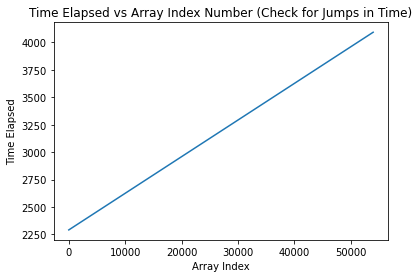

done
 
 Binned Spike Rates: 
 [[29.94011976  0.         29.94011976 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [29.94011976  0.         29.94011976 ...  0.          0.
  59.88023952]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.         29.94011976 ...  0.          0.
  59.88023952]] 

 Bin Times: 
 [2290.85990358 2290.8932633  2290.92662301 ... 4092.15627522 4092.1896345
 4092.22299378] 


In [167]:
ts = get_presentation_times(stim_data)
dt = np.round(ts[1] - ts[0], decimals=4)  # time step 
spike_times = get_spike_data(session, stim_data)
ts_smoothed, spike_times_smoothed, jumps = smooth_times(ts, spike_times, stim_data)

plt.title("Time Elapsed vs Array Index Number (Check for Jumps in Time)")
plt.xlabel('Array Index')
plt.ylabel("Time Elapsed")
plt.plot((ts_smoothed))
plt.show()

num_timesteps_bin_width = 1 # bin width in number of time steps
binned_spikes, bin_times = bin_spikes(ts_smoothed, spike_times_smoothed, num_timesteps_bin_width, stim_data['units'])
print(' \n Binned Spike Rates: \n {0} '.format(binned_spikes / (num_timesteps_bin_width * dt)))
print('\n Bin Times: \n {0} '.format(bin_times))


### Z-Score Spike Rates & Align Spikes to Stimulus Frames

In [197]:
def z_score(arr):
    '''
        Transform 2d array to zero mean unit variance data along the time axis (2nd dim).
        
    '''
    
    means = np.mean(arr, axis = 1, keepdims = True)
    stds = np.std(arr, axis = 1, keepdims = True)
    
    arr -= means
    arr /= stds
    
    return arr

def z_score_binned_spikes(binned_spikes, jumps):
    '''
    Z score binned spikes along the time axis to have zero mean and unit variance. Performs process over each
    time interval separated by jumps
    '''
    #TODO: Finish Implementation, Now only implemented for one jump
#     binned_spikes[:, :jumps[0][0]] = z_score(binned_spikes[:, :jumps[0][0]])
#     binned_spikes[:, jumps[0][0]:] = z_score(binned_spikes[:, jumps[0][0]:])

    return z_score(binned_spikes)

def align_frames_spike_rates(binned_spikes, movie, num_timesteps_bin_width = 1):
    '''
    Return spike rates and image stimulus as aligned matrices.
    Aligning is shifting binned spikes forward in time by [num_timesteps_delay] indices 
    '''
 
    
    # Input data is binned spikes shifted by num_timesteps_delay
    num_samples = binned_spikes.shape[1] - num_timesteps_bin_width
    num_pixels = len(movie[0,:,:].flatten())
    num_neurons = binned_spikes.shape[0]
        
    X = np.zeros((num_neurons, num_samples))    
    Y = np.zeros((num_pixels, num_samples), dtype = np.int16)

    
    for i in range(X.shape[1]):
        Y[:, i] = movie[frames[(i + 1)*num_timesteps_bin_width], :,:].flatten()
        X[:, i] = binned_spikes[:, i]
    return X, Y

C:\Users\fritz\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  """


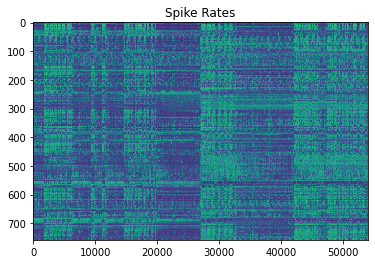

In [198]:
spike_rates = z_score_binned_spikes(binned_spikes / (num_timesteps_bin_width * dt), jumps)
X, Y = align_frames_spike_rates(spike_rates, movie, num_timesteps_bin_width = 1)
#X, Y = align_frames_spike_rates(binned_spikes, movie, num_timesteps_bin_width = )
plt.figure()
plt.imshow(spike_rates, aspect='auto', norm = SymLogNorm(linthresh=.1))
plt.title("Spike Rates")
plt.show()

# Least Squares Regression Baseline 

### Split data into train/test sets, run linear regression on train set & compute test 

In [199]:
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.1, random_state=1)

In [200]:
filters, residuals, rank, sing_vals = np.linalg.lstsq(X_train, Y_train, rcond=None)
#filters = np.linalg.pinv(X_train) @ Y_train

In [201]:
def evaluate_filters(X_test, Y_test, filters):
    '''
    Evaluate a set of linear filters on a test set of X_test 
    neuron activities, comparing to Y_test true images. Return the 
    average percent error over the set 
    '''
    num_samples = X_test.shape[0]
    avg_pct_err = 0

    for j in range(num_samples):
        avg_pct_err += pct_difference_rmse(X_test[j,:]@ filters, Y_test[j,:])
        
    return avg_pct_err / num_samples

def pct_difference_rmse(x, y):
    '''
    Given two  vectors x and y (numpy arrays), return the percent
    difference between the two vectors according to the vector norm:
    ||x - y|| / || y ||
    '''
    return np.linalg.norm(x - y)  / np.linalg.norm(y)  

In [202]:
train_error = evaluate_filters(X_train, Y_train, filters)
print('Train Error: {0}'.format(train_error))

Train Error: 0.7915750933151151


In [203]:
test_error = evaluate_filters(X_test, Y_test, filters)
print('Test Error: {0}'.format(test_error))

Test Error: 0.8017020923180004


In [204]:
y_hat_train = X_train @ filters

In [205]:
y_hat_test = X_test @ filters

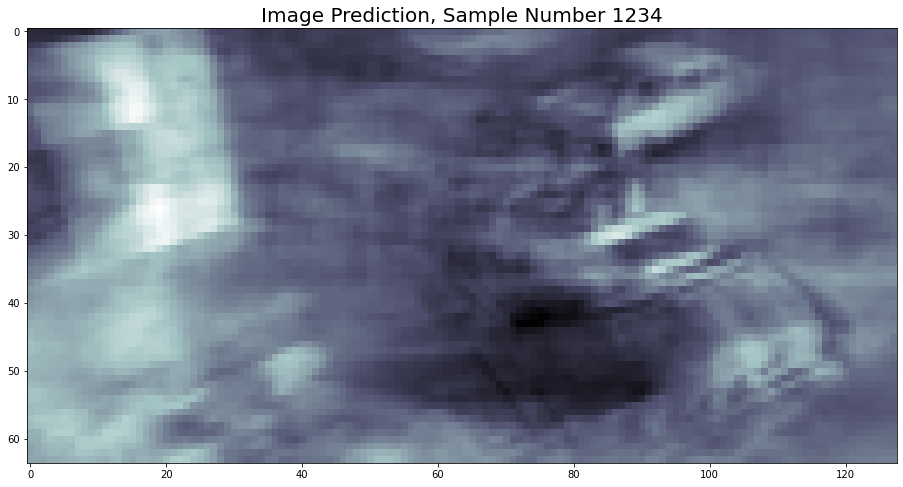

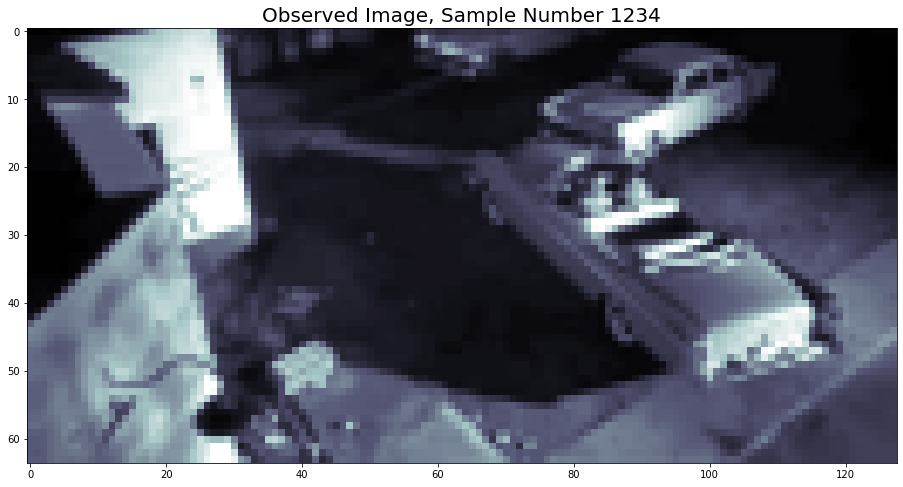

In [213]:
sample_num = 1234


plt.figure(figsize=(16,8))
plt.title("Image Prediction, Sample Number {0}".format(sample_num), fontsize=20)
plt.imshow(y_hat_test[sample_num, :].reshape(v_res, h_res) + 128, cmap='bone')
plt.savefig('trained_prediction.png',bbox_inches='tight')

plt.figure(figsize=(16,8))
plt.title("Observed Image, Sample Number {0}".format(sample_num), fontsize=20)
plt.imshow(Y_test[sample_num, :].reshape(v_res, h_res) + 128, cmap='bone')
plt.savefig('trained_actual.png',bbox_inches='tight')

plt.show()

In [208]:
np.max(movie[10,:,:])

130